In [200]:
import cv2
import numpy as np
from itertools import count
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, EssentialMatrixTransform
import matplotlib.pyplot as plt

vid_path = '5.hevc'

def generate_frames(vid_path):
    video = cv2.VideoCapture(vid_path, cv2.CAP_FFMPEG)
    _, prev_frame = video.read()
    for t in count():
      ret, curr_frame = video.read()
      if not ret:
        break
      yield prev_frame, curr_frame
      prev_frame = curr_frame
    video.release()
    cv2.destroyAllWindows()

def extractFeatures(frame):
  orb = cv2.ORB_create()
  # only works on b/w images
  pts = cv2.goodFeaturesToTrack(np.mean(frame,axis=2).astype(np.uint8), 3000, 0.01, minDistance=7)
  # we need kp class to feed it into ORB.compute to get descriptors
  kps = [cv2.KeyPoint(x=f[0][0], y=f[0][1], size=10) for f in pts]
  kps, des = orb.compute(frame, kps)
  return np.array([(kp.pt[0], kp.pt[1]) for kp in kps]), des

def bfmatcher(kps, dess):
  bf = cv2.BFMatcher(cv2.NORM_HAMMING)
  # find closest descriptors between frames, hamming norm for ORB (BRIEF, BRISK...)
  # they are binary string types
  # L1, L2 for SIFT/SURF
  matches = bf.knnMatch(dess[0], dess[1], k=2)
  res = []
  # DMatch obj: distance (the lower the better)
  # trainIdx: index of the descriptor in train desc
  # queryIdx: index of the descriptor in query desc
  # imgIdx: index of the train image
  for m,n in matches:
    # Lowe's ratio test
    # https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    if m.distance < 0.75 * n.distance:
        kp1 = kps[0][m.queryIdx]
        kp2 = kps[1][m.trainIdx]
        res.append((kp1, kp2))
  res = np.array(res)
  res = normalize(res)
  # prune the outliers by fitting F or E (random sampling of the data)
  assert len(res)>=8, 'not enough points'
  model, inliers = ransac((res[:,0],
                          res[:,1]),
                          FundamentalMatrixTransform, 
                          #EssentialMatrixTransform,
                          min_samples=8,
                          residual_threshold=0.5, 
                          max_trials=200)
                          
  # for the sake of testing
  F = model.params
  dist = []
  p1 = add_third(res[inliers,0])
  p2 = add_third(res[inliers,1])
  for q, w in zip(p1,p2):
    dist.append(q.T@F@w)
  dist = np.array(dist)
  print (np.mean(dist))
  print (np.std(dist))

  plt.plot(dist)
  res = denormalize(res)
  #print (f'good kps: {len(res[inliers])/len(res)*100:.2f}% out of {len(res)}')
  return res[inliers, 0], res[inliers, 1]

w = 1164
h = 874
F = 910

K = [[F, 0, w//2],
     [0, F, h//2],
     [0, 0, 1]]
def normalize(x):
  x[:,0] -= w//2
  x[:,1] -= h//2  
  return x
def denormalize(x):
  x[:,0] += w//2
  x[:,1] += h//2
  return x
def add_third(x):
  return np.pad(x, pad_width = ((0,0), (0,1)) ,constant_values=1)
def remove_third(x):
  return x[:,[0,1]]


-0.6659356037322242
1.1940304567803133
1.2402362374907012
1.491507990788132
-0.9802935765560209
1.1305661753529659
0.9185591604638166
1.434201154592637
-1.0134470572193535
1.409563003942178
0.2340591760463703
1.8647672380266165
0.8552871475985376
1.6252221857641336
-0.5643938950443659
1.6271763871378877
-0.013037194969872089
1.751845935256155
-0.6698202108596532
1.6745996448696747
-1.2468474917252175
1.6646328940862978
-1.3413552864867047
0.660965108214043
-1.430515969840792
0.5156380582092346
1.267123486491228
0.7362196299542535
-0.004192120966640277
2.3567260460309396
1.3372019706320188
0.2864160661799131
-0.393229262021909
1.6253459418069633


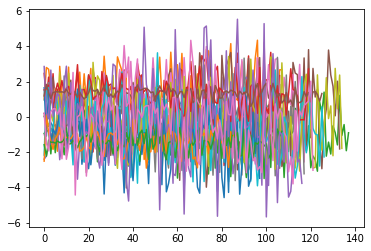

In [201]:
for p, c in generate_frames(vid_path):

  kps_1, des_1 = extractFeatures(p)
  kps_2, des_2 = extractFeatures(c)

  p1, p2 = bfmatcher([kps_1, kps_2], [des_1, des_2])
  
  for p in p2:
    cv2.circle(c, (int(p[0]), int(p[1])), 1, (255,255,0)) 
  
  for k1, k2 in zip(p1, p2):
    cv2.line(c, tuple(k1.astype(int)), tuple(k2.astype(int)), (0,200,200), 1)
  
  cv2.imshow('v', c)
  key = cv2.waitKey(1)
  if key == ord('q'):
    break
  
cv2.destroyAllWindows()